In [36]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from  torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import time
import seaborn as sn
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [38]:
data_dir = 'datasets/v2/animals'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [39]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
pre_trained_model_normalization = transforms.Normalize(mean=mean, std=std)

data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                                pre_trained_model_normalization]),
    'validate': transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                pre_trained_model_normalization]),
    'test': transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                pre_trained_model_normalization])
}

datasets = {
    'train':    ImageFolder(train_dir, transform=data_transforms['train']),
    'validate': ImageFolder(valid_dir, transform=data_transforms['validate']),
    'test':     ImageFolder(test_dir, transform=data_transforms['test'])
}

dataloaders = {
    'train':    DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'validate': DataLoader(datasets['validate'], batch_size=32, shuffle=True),
    'test':     DataLoader(datasets['test'], batch_size=32, shuffle=True)
}

label_mapping = [k for k, v in datasets['validate'].class_to_idx.items()]
print(len(label_mapping), 'classes in this dataset')
print(label_mapping)

3 classes in this dataset
['absent', 'cat', 'dog']


Class: dog, Shape: torch.Size([3, 224, 224])
Class: cat, Shape: torch.Size([3, 224, 224])
Class: absent, Shape: torch.Size([3, 224, 224])
Class: dog, Shape: torch.Size([3, 224, 224])


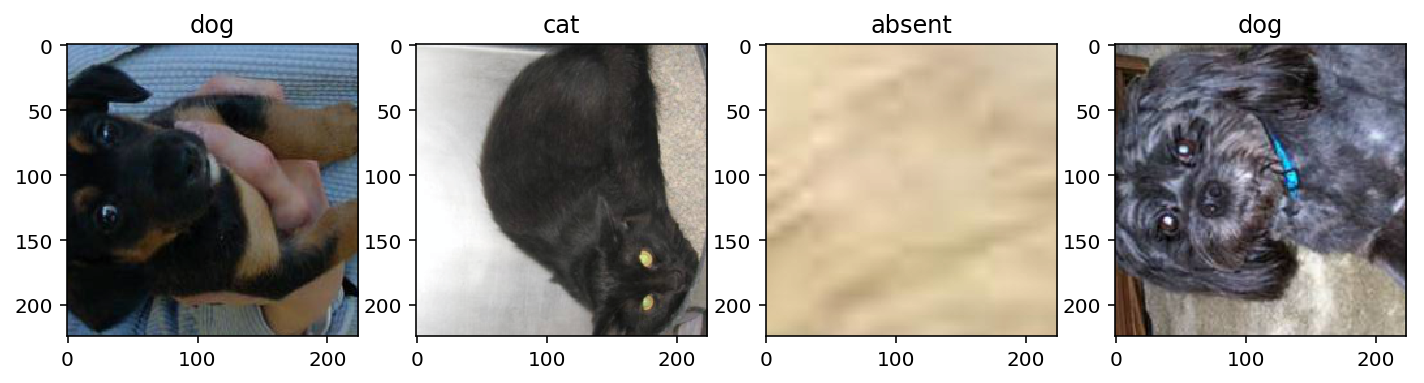

In [42]:
def show4(dataloader, label_mapping):
    dataiter = iter(dataloader)
    fig, ax = plt.subplots(figsize=(12, 10), ncols=4)

    batch = next(dataiter)
    labels = batch[1][0:4]
    images = batch[0][0:4]
    for i in range(4):
        title = label_mapping[labels[i].item()]
        print(f'Class: {title}, Shape: {images[i].shape}')
    
        image = images[i].numpy().T
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax[i].set_title(title)
        ax[i].imshow(image)


show4(dataloaders['validate'], label_mapping)

In [43]:
def build_network(architecture, out_features, hidden_layers, label_mapping, log_model=False):

  model = getattr(torchvision.models, architecture)(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  # Find the number of in features the classifier expects
  try:
      iter(model.classifier)
  except TypeError:
      in_features = model.classifier.in_features
  else:
      in_features = model.classifier[0].in_features

  hidden = [in_features] + hidden_layers

  layers = []
  for i, (x, y) in enumerate(zip(hidden[:-1], hidden[1:])):
    layers.append((f'fc{i}', nn.Linear(x, y)))
    layers.append((f'relu{i}', nn.ReLU()))
    layers.append((f'dropout{i}', nn.Dropout(p=0.2)))
  layers.append(('fc_final', nn.Linear(hidden_layers[-1], out_features)))
  layers.append(('log_output', nn.LogSoftmax(dim=1)))

  classifier = nn.Sequential(OrderedDict(layers))
  if log_model:
    print('Classifier:', classifier)

  classifier.out_features = out_features
  classifier.hidden_layers = hidden_layers
  classifier.label_mapping = label_mapping
  model.architecture = architecture
  
  model.classifier = classifier
  return model


model = build_network('vgg16', 3, [1000, 256, 64, 32], label_mapping, log_model=True)

Classifier: Sequential(
  (fc0): Linear(in_features=25088, out_features=1000, bias=True)
  (relu0): ReLU()
  (dropout0): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1000, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc_final): Linear(in_features=32, out_features=3, bias=True)
  (log_output): LogSoftmax()
)


In [44]:
def save(model, filepath):
  checkpoint = {
    'out_features': model.classifier.out_features,
    'hidden_layers': model.classifier.hidden_layers,
    'architecture': model.architecture,
    'state_dict': model.state_dict(),
    'label_mapping': model.classifier.label_mapping,
  }
  torch.save(checkpoint, filepath)

def load(filepath):
  checkpoint = torch.load(filepath)
  model = build_network(checkpoint['architecture'],
                        checkpoint['out_features'],
                        checkpoint['hidden_layers'],
                        checkpoint['label_mapping'])
  model.load_state_dict(checkpoint['state_dict'])

  return model

In [45]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [46]:
def train(model, criterion, optimizer, trainloader, testloader, epochs=1, logging_rate=1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f'Training on device: {device}')

    start_time = time.time()
    train_losses, eval_losses = [], []
    train_accuracies, eval_accuracies = [], []
    best_eval_accuracy = 0

    for e in range(epochs):
        train_loss = 0
        train_accuracy = 0
        eval_loss = 0
        eval_accuracy = 0

        for images, labels in trainloader: 
            model.train()
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            with torch.no_grad():
                model.eval()
                ps = torch.exp(model.forward(images))
                top_p, top_class = ps.topk(1, dim=1)
                train_accuracy += torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
            
        else:
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    model.eval()
                    log_ps = model.forward(images)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    eval_accuracy += torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
                    eval_loss += criterion(log_ps, labels).item()
        
        train_loss /= len(trainloader)
        train_accuracy /= len(trainloader)
        eval_loss /= len(testloader)
        eval_accuracy /= len(testloader)

        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            save(model, 'checkpoint.pth')

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        if logging_rate != 0 and (e+1) % logging_rate == 0:
            interval_time = time.time()  
            print(f'--- Epoch {e + 1} --- Time elapsed: {int(interval_time - start_time)} seconds')
            print(f'train_accuracy: {round(train_accuracy*100, 2)}%')
            print(f'eval_accuracy:  {round(eval_accuracy*100, 2)}%')
            print(f'train_loss:     {round(train_loss, 4)}')
            print(f'eval_loss:      {round(eval_loss, 4)}')

    print(f'Best model with evaluation accuracy of {round(best_eval_accuracy*100, 2)}% saved to checkpoint.pth and returned')
    model = load('checkpoint.pth')
 
    return model, (train_accuracies, eval_accuracies, train_losses, eval_losses)


model, stats = train(model, criterion, optimizer, dataloaders['train'], dataloaders['validate'], epochs=3, logging_rate=1)

Training on device: cuda:0
--- Epoch 1 --- Time elapsed: 372 seconds
train_accuracy: 96.28%
eval_accuracy:  98.94%
train_loss:     0.1317
eval_loss:      0.03
--- Epoch 2 --- Time elapsed: 743 seconds
train_accuracy: 96.81%
eval_accuracy:  98.5%
train_loss:     0.096
eval_loss:      0.0541
--- Epoch 3 --- Time elapsed: 1114 seconds
train_accuracy: 96.9%
eval_accuracy:  98.94%
train_loss:     0.0948
eval_loss:      0.0452
Best model with evaluation accuracy of 98.94% saved to checkpoint.pth and returned


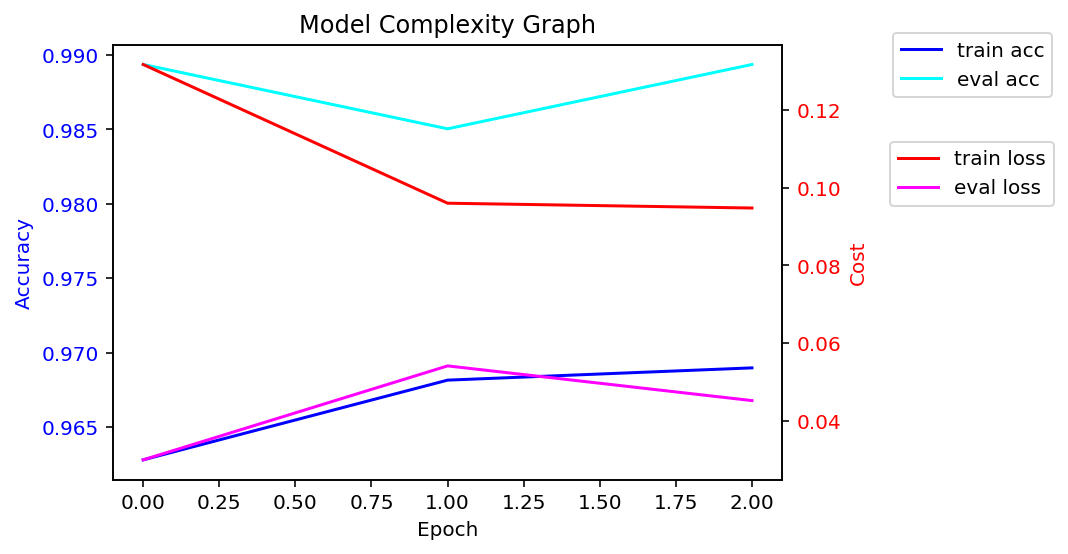

In [47]:
def modelComplexityGraph(train_accuracies, eval_accuracies, train_losses, eval_losses):
  fig, ax1 = plt.subplots()
  epochs = len(train_accuracies)
  ax1.set_title('Model Complexity Graph')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy', color="blue")
  ax1.tick_params(axis='y', labelcolor='blue')
  ax1.plot(range(epochs), train_accuracies, color='blue', label='train acc')
  ax1.plot(range(epochs), eval_accuracies, color='cyan', label='eval acc')
  ax2 = ax1.twinx()
  ax2.set_ylabel('Cost', color="red")
  ax2.tick_params(axis='y', labelcolor='red')
  ax2.plot(range(epochs), train_losses, color='red', label='train loss')
  ax2.plot(range(epochs), eval_losses, color='magenta', label='eval loss')

  ax1.legend(bbox_to_anchor=(1.15, 1.05))
  ax2.legend(bbox_to_anchor=(1.42, 0.8))


modelComplexityGraph(*stats)

Evaluation Loss:     0.0295
Evaluation Accuracy: 98.9%
Confusion Matrix:


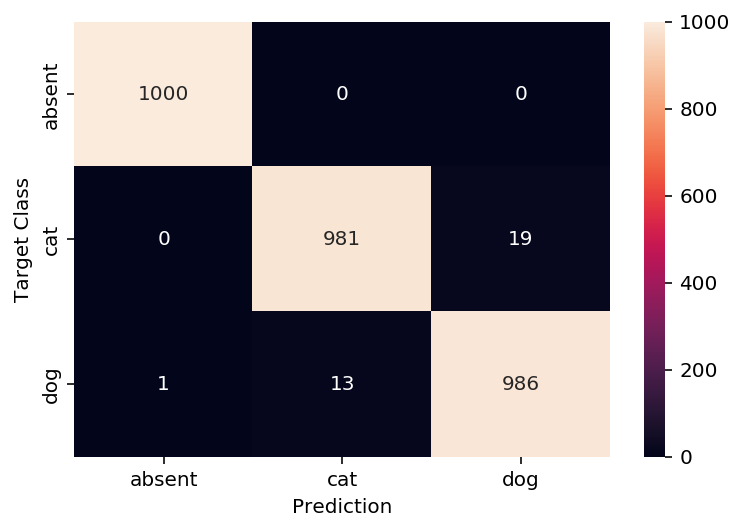

In [48]:
def validate(model, testloader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  eval_accuracy = 0
  eval_loss = 0
  num_features = model.classifier.out_features
  confusion_matrix = np.zeros((num_features, num_features))

  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      model.eval()
      log_ps = model.forward(images)
      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(1, dim=1)
      eval_accuracy += torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
      eval_loss += criterion(log_ps, labels).item()
      for prediction, target in zip(top_class, labels):
        confusion_matrix[target][prediction[0]] += 1

  eval_loss /= len(testloader)
  eval_accuracy /= len(testloader)
  
  print(f'Evaluation Loss:     {round(eval_loss, 4)}' )
  print(f'Evaluation Accuracy: {round(eval_accuracy * 100, 2)}%')
  print('Confusion Matrix:')
  cm = pd.DataFrame(confusion_matrix, label_mapping, label_mapping)

  sn.heatmap(cm, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Target Class')
  plt.show()


validate(model, dataloaders['test'])

Prediction took 1.3992786407470703 milliseconds


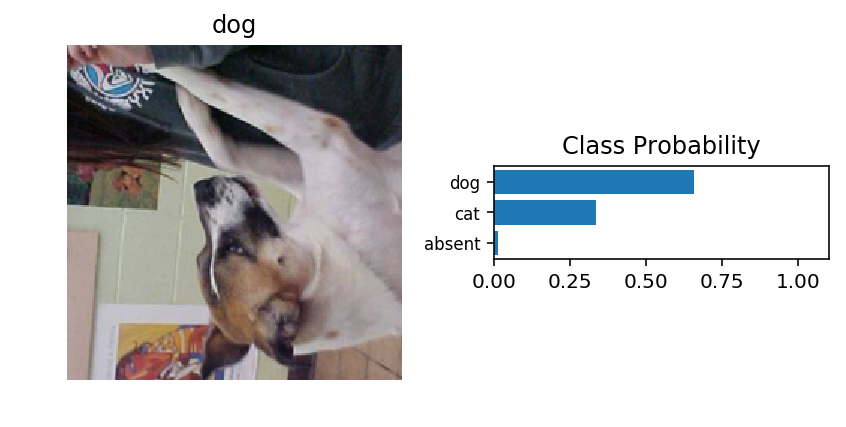

Prediction took 1.3942718505859375 milliseconds


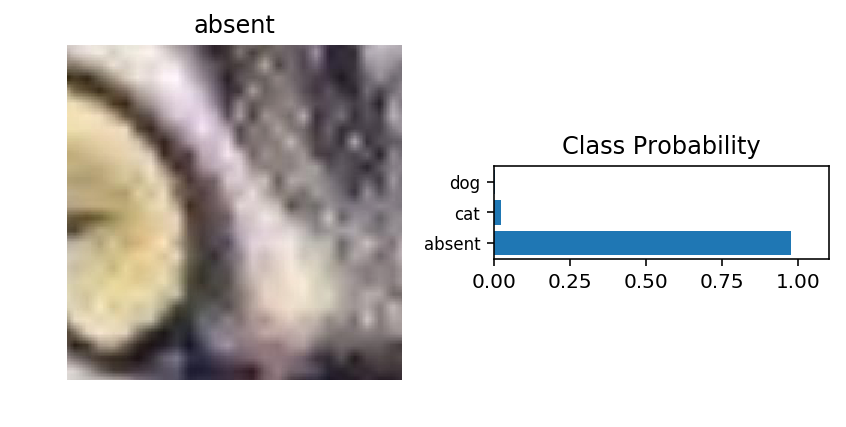

Prediction took 1.3973712921142578 milliseconds


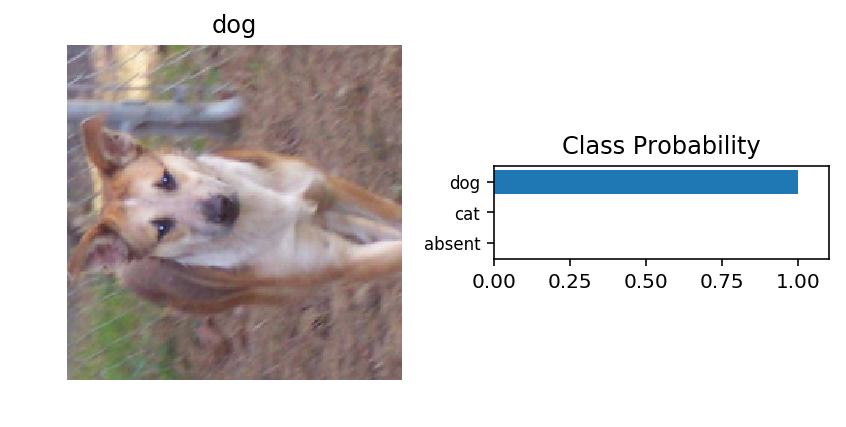

In [49]:
def classify(model, image, label_idx):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  with torch.no_grad():
    model.eval()
    img_tensor = image.reshape(1,3,224,224).to(device)

    start_time = time.time()
    ps = torch.exp(model.forward(img_tensor))
    end_time = time.time()
    ps = ps.data.cpu().numpy().squeeze()
    
    image = image.numpy().T
    image = std * image + mean
    image = np.clip(image, 0, 1)

    print(f"Prediction took {(end_time-start_time) * 1000} milliseconds")
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(model.classifier.label_mapping[label_idx])
    ax2.barh(np.arange(3), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(3))
    ax2.set_yticklabels(model.classifier.label_mapping, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

    
image, label = next(iter(dataloaders['test']))
classify(model, image[0], label[0].item())
classify(model, image[1], label[1].item())
classify(model, image[2], label[2].item())